# P4



## Exploratory Data Analysis

In [1]:
# %matplotlib widget

import pandas as pd
import pandasql as psql
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
customers = pd.read_csv('dataset/olist_customers_dataset.csv')
geolocation = pd.read_csv('dataset/olist_geolocation_dataset.csv')
order_items = pd.read_csv('dataset/olist_order_items_dataset.csv')
order_payments = pd.read_csv('dataset/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('dataset/olist_order_reviews_dataset.csv')
orders = pd.read_csv('dataset/olist_orders_dataset.csv')
products = pd.read_csv('dataset/olist_products_dataset.csv')
sellers = pd.read_csv('dataset/olist_sellers_dataset.csv')
product_category_name = pd.read_csv('dataset/product_category_name_translation.csv')



### Locations

In [3]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [4]:
geolocation = geolocation.groupby('geolocation_city')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()
geolocation.set_index('geolocation_city')

,geolocation_lat,geolocation_lng
geolocation_city,,
* cidade,-25.571748,-49.334374
...arraial do cabo,-22.969370,-42.029834
4o. centenario,-24.271860,-53.069433
4º centenario,-24.279801,-53.074723
abadia de goias,-16.767063,-49.438089
...,...,...
áurea,-27.695009,-52.055076
ângulo,-23.195024,-51.917294
érico cardoso,-13.393047,-42.134282


In [5]:
city_coord = geolocation[geolocation.geolocation_city == 'abare'].to_numpy()
city_coord[0][1]


-8.689967452179038

In [6]:
from haversine import haversine, Unit

olist_hq_loc = (-25.430296283573938, -49.29199547244041) # olist head quarter position

def position(row):
    return haversine(olist_hq_loc, (row['geolocation_lat'], row['geolocation_lng']), unit=Unit.KILOMETERS)

def distance_btw_cities(citya, cityb):
    citya_coord = geolocation[geolocation.geolocation_city == citya].to_numpy()
    # print(citya_coord)
    cityb_coord = geolocation[geolocation.geolocation_city == cityb].to_numpy()
    # print(cityb_coord)
    return haversine((citya_coord[0][1], citya_coord[0][2]), (cityb_coord[0][1], cityb_coord[0][2]))

def haversine_vectorize(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return np.around(km, 0)



In [7]:
distance_btw_cities('abare', 'abrantes')

470.724756693975

### Customers


In [8]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [9]:


print(customers['customer_unique_id'].nunique())
print(customers['customer_id'].nunique())
# unique ID and customer id are not the same 
# so, will use customer_unique_id for joining

customers.drop('customer_zip_code_prefix', axis=1, inplace=True)
customers.drop('customer_state', axis=1, inplace=True)



96096
99441


### Products

In [10]:
#  join on product_id
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [11]:
# no. unique categories
products['product_category_name'].nunique()


73

In [12]:
products.drop('product_name_lenght', axis=1, inplace=True)
products.drop('product_description_lenght', axis=1, inplace=True)
products.drop('product_photos_qty', axis=1, inplace=True)
# we create 'volume' feature
products['product_volume'] = products['product_length_cm'] * products['product_height_cm'] * products['product_width_cm']
products.drop('product_length_cm', axis=1, inplace=True)
products.drop('product_height_cm', axis=1, inplace=True)
products.drop('product_width_cm', axis=1, inplace=True)

### Order Items

In [13]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [14]:
# is there orders that contains several items ? if yes what is the proportion in the dataset ? 
grouped = order_items.groupby(['order_id'])[['order_id', 'order_item_id']].count().sort_values(by='order_item_id' , ascending=False)\
    .gt(1).sum()['order_id'] 

(grouped / order_items.shape[0]) * 100

# less than 10% of the dataset relates to orders containing several items, which is negligeable

8.702174877940523

In [15]:
# who are the best sellers ?
order_items.groupby(['seller_id'])\
    .agg({'product_id': 'count', 'price': 'sum'})\
    .reset_index()\
    .sort_values(by=['product_id', 'price'], ascending=False)\
    .rename(columns={'product_id' : 'product_id_count', 'price': 'price_sum'})

,seller_id,product_id_count,price_sum
1235,6560211a19b47992c3666cc44a7e94c0,2033,123304.83
881,4a3ca9315b744ce9f8e9374361493884,1987,200472.92
368,1f50f920176fa81dab994f9023523100,1931,106939.21
2481,cc419e0650a3c5ba77189a1882b7556a,1775,104288.42
2643,da8622b14eb17ae2831f4ac5b9dab84a,1551,160236.57
...,...,...,...
627,34aefe746cd81b7f3b23253ea28bef39,1,8.00
1370,702835e4b785b67a084280efca355756,1,7.60
373,1fa2d3def6adfa70e58c276bb64fe5bb,1,6.90
1465,77128dec4bec4878c37ab7d6169d6f26,1,6.50


In [16]:
# several sellers may exists for one single order (providing several products)
grouped = order_items.groupby(['order_id'])\
    .agg({'seller_id': 'nunique'})\
    .sort_values(by='seller_id', ascending=False)\
    .gt(1).sum()['seller_id']

(grouped / order_items.shape[0]) * 100

# less than 2% of the dataset contains orders that contains several items sold be different sellers, which is negligeable
    

1.1344873501997337

In [17]:
#  some orders have several products, so compute the overal sum for each order
order_items.groupby(['order_id'])\
    .agg({'product_id': 'count', 'price': 'sum', 'seller_id' : 'nunique'})\
    .reset_index()\
    .sort_values(by=['seller_id', 'price'], ascending=False)\
    .rename(columns={'product_id' : 'product_id_count', 'price': 'price_sum'})
    # .sort_values(by=['product_id', 'price'], ascending=False)\


,order_id,product_id_count,price_sum,seller_id
10831,1c11d0f4353b31ac3417fbfa5f0f2a8a,7,306.77,5
79967,cf5c8d9f52807cb2d2f0a0ff54c478da,6,163.19,5
53796,8c2b13adf3f377c8f2b06b04321b0925,4,441.89,4
55847,91be51c856a90d7efe86cf9d082d6ae3,4,339.44,4
11231,1d23106803c48c391366ff224513fb7f,4,148.79,4
...,...,...,...,...
21805,38bcb524e1c38c2c1b60600a80fc8999,1,2.90,1
89758,e8bbc1d69fee39eee4c72cb5c969e39d,1,2.29,1
93208,f1d5c2e6867fa93ceee9ef9b34a53cbf,1,2.20,1
24174,3ee6513ae7ea23bdfab5b9ab60bffcb5,1,0.85,1


In [18]:
order_items.drop('shipping_limit_date', axis=1, inplace=True)
order_items.drop('freight_value', axis=1, inplace=True)
order_items.drop('order_item_id', axis=1, inplace=True)


### Order Payments

In [19]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [20]:
# Keep only the payment value
order_payments = order_payments[['order_id', 'payment_value']]
order_payments


,order_id,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,65.71
3,ba78997921bbcdc1373bb41e913ab953,107.78
4,42fdf880ba16b47b59251dd489d4441a,128.45
...,...,...
103881,0406037ad97740d563a178ecc7a2075c,363.31
103882,7b905861d7c825891d6347454ea7863f,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,47.77
103884,b8b61059626efa996a60be9bb9320e10,369.54


### Order Review

In [21]:
#  just keep review_score, review_creation_date, join on order_id
order_reviews.info()
order_reviews.drop('review_id', axis=1, inplace=True)
order_reviews.drop('review_comment_title', axis=1, inplace=True)
order_reviews.drop('review_comment_message', axis=1, inplace=True)
order_reviews.drop('review_answer_timestamp', axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [22]:
order_reviews['review_creation_date'] = pd.to_datetime(order_reviews['review_creation_date'])

### Orders

In [23]:
#  join on order_id
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [24]:
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [25]:
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

In [26]:
orders.drop('order_status', axis=1, inplace=True)
orders.drop('order_approved_at', axis=1, inplace=True)
orders.drop('order_delivered_carrier_date', axis=1, inplace=True)

In [27]:
# feature engineering : does he parcel arrived on time as predicted ?
orders['delivered_on_time'] = np.sign((orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']).dt.days) 
orders['delivered_on_time'] = (orders['delivered_on_time'] == 1) | (orders['delivered_on_time'] == 0)


# feature engineering, what was the delivery delay: short, medium, long, very long ? which corresponds to quantiles 25%, 50%, 75%, 100%
orders['order_delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days
orders['order_delivery_time'].describe()

count    96476.000000
mean        12.094086
std          9.551746
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: order_delivery_time, dtype: float64

In [28]:

slices = [1, 2, 3, 4]
c, bins = pd.qcut(orders['order_delivery_time'], len(slices), labels=slices, retbins=True)
print(bins)
orders['order_delivery_lasting_cat'] = c.values

# orders

[  0.   6.  10.  15. 209.]


In [29]:
orders.groupby('order_delivery_lasting_cat').count()

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delivered_on_time,order_delivery_time
order_delivery_lasting_cat,,,,,,,
1,26045,26045,26045,26045,26045,26045,26045
2,26053,26053,26053,26053,26053,26053,26053
3,21168,21168,21168,21168,21168,21168,21168
4,23210,23210,23210,23210,23210,23210,23210


In [30]:
#  join on customer_id
orders.drop('order_estimated_delivery_date', axis=1, inplace=True)
orders.drop('order_delivery_time', axis=1, inplace=True)

### Sellers

In [31]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [32]:
sellers.drop(['seller_state', 'seller_zip_code_prefix'], axis=1, inplace=True)

## Merge datasets

In [33]:
olist = customers.merge(orders, on='customer_id', how='left')
olist = olist.merge(order_items, on='order_id', how='outer')
olist = olist.merge(order_reviews, on='order_id', how='outer')
olist = olist.merge(products, on='product_id', how='outer')
olist = olist.merge(sellers, on='seller_id', how='outer')

olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114092 entries, 0 to 114091
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    114092 non-null  object        
 1   customer_unique_id             114092 non-null  object        
 2   customer_city                  114092 non-null  object        
 3   order_id                       114092 non-null  object        
 4   order_purchase_timestamp       114092 non-null  datetime64[ns]
 5   order_delivered_customer_date  110839 non-null  datetime64[ns]
 6   delivered_on_time              114092 non-null  bool          
 7   order_delivery_lasting_cat     110839 non-null  category      
 8   product_id                     113314 non-null  object        
 9   seller_id                      113314 non-null  object        
 10  price                          113314 non-null  float64       
 11  

In [34]:
olist.drop(['customer_id', 'order_id', 'product_id', 'seller_id'], axis=1, inplace=True)


In [35]:
olist.dropna(inplace=True)

In [36]:

olist.head()

,customer_unique_id,customer_city,order_purchase_timestamp,order_delivered_customer_date,delivered_on_time,order_delivery_lasting_cat,price,review_score,review_creation_date,product_category_name,product_weight_g,product_volume,seller_city
0,861eff4711a542e4b93843c6dd7febb0,franca,2017-05-16 15:05:35,2017-05-25 10:35:35,True,2,124.99,4.0,2017-05-26,moveis_escritorio,8683.0,107136.0,itaquaquecetuba
1,9eae34bbd3a474ec5d07949ca7de67c0,santarem,2017-11-09 00:50:13,2017-11-28 00:09:50,True,4,112.99,1.0,2017-11-29,moveis_escritorio,8683.0,107136.0,itaquaquecetuba
2,9eae34bbd3a474ec5d07949ca7de67c0,santarem,2017-11-09 00:50:13,2017-11-28 00:09:50,True,4,112.99,1.0,2017-11-29,moveis_escritorio,8683.0,107136.0,itaquaquecetuba
3,3c799d181c34d51f6d44bbbc563024db,nova santa rita,2017-05-07 20:11:26,2017-05-26 09:54:04,True,4,124.99,3.0,2017-05-27,moveis_escritorio,8683.0,107136.0,itaquaquecetuba
4,23397e992b09769faf5e66f9e171a241,mage,2018-02-03 19:45:40,2018-02-28 21:09:00,True,4,106.99,4.0,2018-03-01,moveis_escritorio,8683.0,107136.0,itaquaquecetuba


<AxesSubplot:ylabel='None'>

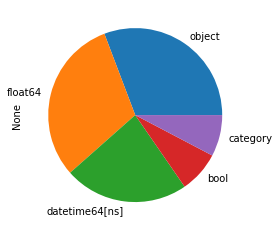

In [37]:
olist.dtypes.value_counts().plot.pie()

In [38]:
olist.select_dtypes('number').describe()

,price,review_score,product_weight_g,product_volume
count,108478.000000,108478.000000,108478.000000,108478.000000
mean,119.797846,4.083160,2091.902754,15190.741256
std,180.453399,1.345792,3739.598453,23186.475565
min,0.850000,1.000000,0.000000,168.000000
25%,39.900000,4.000000,300.000000,2856.000000
50%,74.900000,5.000000,700.000000,6512.000000
75%,134.000000,5.000000,1800.000000,18240.000000
max,6735.000000,5.000000,40425.000000,296208.000000


In [39]:
olist.select_dtypes(["object", "category"])

,customer_unique_id,customer_city,order_delivery_lasting_cat,product_category_name,seller_city
0,861eff4711a542e4b93843c6dd7febb0,franca,2,moveis_escritorio,itaquaquecetuba
1,9eae34bbd3a474ec5d07949ca7de67c0,santarem,4,moveis_escritorio,itaquaquecetuba
2,9eae34bbd3a474ec5d07949ca7de67c0,santarem,4,moveis_escritorio,itaquaquecetuba
3,3c799d181c34d51f6d44bbbc563024db,nova santa rita,4,moveis_escritorio,itaquaquecetuba
4,23397e992b09769faf5e66f9e171a241,mage,4,moveis_escritorio,itaquaquecetuba
...,...,...,...,...,...
114085,38e482d7770a43f5929378c4dec76d5e,parnamirim,3,beleza_saude,niteroi
114086,393c2ace23a135d0bcc7e70167448e16,barreiras,2,bebidas,salvador
114088,5c22dbb9d8b5385953f2f1e6d9d115a7,jordania,3,pet_shop,maringa
114090,7f5f43a9394964ac51bc5d1e0204ead4,uruacu,2,ferramentas_jardim,sao jose dos pinhais


In [40]:
olist.select_dtypes(["datetime", "timedelta"])

,order_purchase_timestamp,order_delivered_customer_date,review_creation_date
0,2017-05-16 15:05:35,2017-05-25 10:35:35,2017-05-26
1,2017-11-09 00:50:13,2017-11-28 00:09:50,2017-11-29
2,2017-11-09 00:50:13,2017-11-28 00:09:50,2017-11-29
3,2017-05-07 20:11:26,2017-05-26 09:54:04,2017-05-27
4,2018-02-03 19:45:40,2018-02-28 21:09:00,2018-03-01
...,...,...,...
114085,2018-08-16 15:02:31,2018-08-28 22:08:29,2018-08-29
114086,2018-07-20 09:42:40,2018-07-27 11:54:15,2018-07-28
114088,2018-08-01 18:58:49,2018-08-13 23:16:46,2018-08-14
114090,2018-08-18 20:59:58,2018-08-28 18:16:44,2018-08-29


In [41]:
olist.select_dtypes("bool")

,delivered_on_time
0,True
1,True
2,True
3,True
4,True
...,...
114085,True
114086,True
114088,True
114090,True


### Clean-Up

In [42]:
olist['order_delivery_lasting_cat'] = olist['order_delivery_lasting_cat'].astype(int)

In [43]:
olist

,customer_unique_id,customer_city,order_purchase_timestamp,order_delivered_customer_date,delivered_on_time,order_delivery_lasting_cat,price,review_score,review_creation_date,product_category_name,product_weight_g,product_volume,seller_city
0,861eff4711a542e4b93843c6dd7febb0,franca,2017-05-16 15:05:35,2017-05-25 10:35:35,True,2,124.99,4.0,2017-05-26,moveis_escritorio,8683.0,107136.0,itaquaquecetuba
1,9eae34bbd3a474ec5d07949ca7de67c0,santarem,2017-11-09 00:50:13,2017-11-28 00:09:50,True,4,112.99,1.0,2017-11-29,moveis_escritorio,8683.0,107136.0,itaquaquecetuba
2,9eae34bbd3a474ec5d07949ca7de67c0,santarem,2017-11-09 00:50:13,2017-11-28 00:09:50,True,4,112.99,1.0,2017-11-29,moveis_escritorio,8683.0,107136.0,itaquaquecetuba
3,3c799d181c34d51f6d44bbbc563024db,nova santa rita,2017-05-07 20:11:26,2017-05-26 09:54:04,True,4,124.99,3.0,2017-05-27,moveis_escritorio,8683.0,107136.0,itaquaquecetuba
4,23397e992b09769faf5e66f9e171a241,mage,2018-02-03 19:45:40,2018-02-28 21:09:00,True,4,106.99,4.0,2018-03-01,moveis_escritorio,8683.0,107136.0,itaquaquecetuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114085,38e482d7770a43f5929378c4dec76d5e,parnamirim,2018-08-16 15:02:31,2018-08-28 22:08:29,True,3,1750.00,4.0,2018-08-29,beleza_saude,1100.0,3000.0,niteroi
114086,393c2ace23a135d0bcc7e70167448e16,barreiras,2018-07-20 09:42:40,2018-07-27 11:54:15,True,2,145.90,5.0,2018-07-28,bebidas,2250.0,7168.0,salvador
114088,5c22dbb9d8b5385953f2f1e6d9d115a7,jordania,2018-08-01 18:58:49,2018-08-13 23:16:46,True,3,49.90,5.0,2018-08-14,pet_shop,200.0,8960.0,maringa
114090,7f5f43a9394964ac51bc5d1e0204ead4,uruacu,2018-08-18 20:59:58,2018-08-28 18:16:44,True,2,135.98,5.0,2018-08-29,ferramentas_jardim,3211.0,41976.0,sao jose dos pinhais


## Features Engineering & Cleaning

In [44]:
olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108478 entries, 0 to 114091
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_unique_id             108478 non-null  object        
 1   customer_city                  108478 non-null  object        
 2   order_purchase_timestamp       108478 non-null  datetime64[ns]
 3   order_delivered_customer_date  108478 non-null  datetime64[ns]
 4   delivered_on_time              108478 non-null  bool          
 5   order_delivery_lasting_cat     108478 non-null  int64         
 6   price                          108478 non-null  float64       
 7   review_score                   108478 non-null  float64       
 8   review_creation_date           108478 non-null  datetime64[ns]
 9   product_category_name          108478 non-null  object        
 10  product_weight_g               108478 non-null  float64       
 11  

### Product Size and Weight 

In [45]:
olist['product_weight_g'].describe()

count    108478.000000
mean       2091.902754
std        3739.598453
min           0.000000
25%         300.000000
50%         700.000000
75%        1800.000000
max       40425.000000
Name: product_weight_g, dtype: float64

In [46]:
#  product size category
slices = [1, 2, 3, 4]

c, bins = pd.qcut(olist['product_volume'], len(slices), labels=slices, retbins=True)
olist['product_volume']=c.values

c, bins = pd.qcut(olist['product_weight_g'], len(slices), labels=slices, retbins=True)
olist['product_weight'] = c.values


In [47]:
olist['product_weight'] = olist['product_weight'].cat.codes

In [48]:
olist.drop('product_weight_g', axis=1, inplace=True)
olist.drop('product_volume', axis=1, inplace=True) # finally don't need to keep it

### Order timestamps & delays

In [49]:
from datetime import datetime

# olist['purchase_time_hist'] = np.round((np.datetime64(datetime.now()) - olist['order_purchase_timestamp']).dt.days, decimals=0)
olist['order_purchase_timestamp'] = olist['order_purchase_timestamp'].dt.date

### Customers

In [50]:
# get review score and price grouped by customer_Id (only one customer per order)
olist.groupby('customer_unique_id')[['price', 'review_score']]\
    .agg(['count', 'sum', 'mean'])\
    .sort_values(by=('price', 'count'), ascending=False)


price                      review_score  \
                                 count      sum        mean        count   
customer_unique_id                                                         
c8460e4251689ba205045f3ea17884a1    24  4080.00  170.000000           24   
d97b3cfb22b0d6b25ac9ed4e9c2d481b    24  1593.16   66.381667           24   
4546caea018ad8c692964e3382debd19    21    31.80    1.514286           21   
c402f431464c72e27330a67f7b94d4fb    20  2000.00  100.000000           20   
0f5ac8d5c31de21d2f25e24be15bbffb    18  1252.35   69.575000           18   
...                                ...      ...         ...          ...   
5a6bc06cb2b6634abf6db687a6523436     1   159.00  159.000000            1   
5a6a43b78f4354c6bf999401fba32452     1   219.00  219.000000            1   
5a69a2488bab3359156c45baaf59dcee     1    89.90   89.900000            1   
5a67f586c461ff4fe70143d4938bc1a1     1   110.00  110.000000            1   
ffffd2657e2aad2907e67c3e9daecbeb     1    56.99   56.990000            1   

                                             
                                   sum mean  
customer_unique_id                           
c8460e4251689ba205045f3ea17884a1  96.0  4.0  
d97b3cfb22b0d6b25ac9ed4e9c2d481b  24.0  1.0  
4546caea018ad8c692964e3382debd19  21.0  1.0  
c402f431464c72e27330a67f7b94d4fb  20.0  1.0  
0f5ac8d5c31de21d2f25e24be15bbffb  90.0  5.0  
...                                ...  ...  
5a6bc06cb2b6634abf6db687a6523436   1.0  1.0  
5a6a43b78f4354c6bf999401fba32452   4.0  4.0  
5a69a2488bab3359156c45baaf59dcee   4.0  4.0  
5a67f586c461ff4fe70143d4938bc1a1   4.0  4.0  
ffffd2657e2aad2907e67c3e9daecbeb   5.0  5.0  

[91498 rows x 6 columns]

#### Returning Customer

In [51]:
returning_customers = olist['customer_unique_id'].value_counts() > 1
returning_customers = returning_customers[returning_customers == True]
olist['returning_customer'] =  olist['customer_unique_id'].isin(returning_customers.index)


In [52]:
olist.groupby('returning_customer')['customer_unique_id'].count()

returning_customer
False    80117
True     28361
Name: customer_unique_id, dtype: int64

#### Cumulated price orders by customer

In [53]:
cumulated_price = olist.groupby('customer_unique_id')['price'].sum().to_frame().rename(columns={'price': 'cumulated_price'})
cumulated_price


,cumulated_price
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
0000f46a3911fa3c0805444483337064,69.00
0000f6ccb0745a6a4b88665a16c9f078,25.99
0004aac84e0df4da2b147fca70cf8255,180.00
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1570.00
fffea47cd6d3cc0a88bd621562a9d061,64.89
ffff371b4d645b6ecea244b27531430a,89.90


In [54]:
olist = pd.merge(olist, cumulated_price, how='left', on='customer_unique_id')

### Review

#### Review before delivery

In [55]:
olist['review_before_delivery'] = ((olist['review_creation_date'] - olist['order_delivered_customer_date']).dt.days) <= -2

In [56]:
olist.groupby(['review_before_delivery','review_score'])['review_before_delivery'].count()\
    # .plot(kind='pie', subplots=True, legend=True, figsize=(8,8))
    # .hist(by='review_before_delivery', bins=5)

# we can see that if review is made before delivery, review score is very low, so these features may be quite correlated


review_before_delivery  review_score
False                   1.0              8871
                        2.0              3145
                        3.0              8623
                        4.0             20501
                        5.0             61760
True                    1.0              3466
                        2.0               498
                        3.0               525
                        4.0               383
                        5.0               706
Name: review_before_delivery, dtype: int64

In [57]:
olist.drop('order_delivered_customer_date', axis=1, inplace=True)
olist.drop('review_creation_date', axis=1, inplace=True)

#### Average Review score and Trend

In [58]:
# what is the average review score & what is the last review score -> what's the trend 

mean_review = olist.groupby(['customer_unique_id'])['review_score'].mean().to_frame()
mean_review.rename(columns={'review_score' : 'avg_review_score'}, inplace=True)
mean_review

,avg_review_score
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,4.0
0000f46a3911fa3c0805444483337064,3.0
0000f6ccb0745a6a4b88665a16c9f078,4.0
0004aac84e0df4da2b147fca70cf8255,5.0
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,5.0
fffea47cd6d3cc0a88bd621562a9d061,4.0
ffff371b4d645b6ecea244b27531430a,5.0


In [59]:

# merge
olist = pd.merge(olist, mean_review, how='left', on='customer_unique_id')

# engineer & clean
olist['review_score_trend'] = np.sign((olist.review_score - olist.avg_review_score))
olist.drop('avg_review_score', axis=1, inplace=True)

# show result
olist.sort_values(by='review_score_trend', ascending=True)

,customer_unique_id,customer_city,order_purchase_timestamp,delivered_on_time,order_delivery_lasting_cat,price,review_score,product_category_name,seller_city,product_weight,returning_customer,cumulated_price,review_before_delivery,review_score_trend
47050,a54de86aa4370cc93031bb4e99d436b0,sao paulo,2018-04-22,True,1,10.50,2.0,casa_construcao,florianopolis,0,True,116.00,False,-1.0
9734,d05fdf65460ea1bf8735cd5843c3d97d,resende,2018-03-13,False,4,182.00,1.0,esporte_lazer,ribeirao preto,2,True,281.00,True,-1.0
79725,eb8ace0670e08632f5fe8977b669530e,limeira,2017-07-04,True,2,15.99,4.0,telefonia,sao paulo,0,True,50.99,False,-1.0
35349,66e56177b9bf464a930e57edc3694403,sao paulo,2017-09-13,True,1,99.99,3.0,cama_mesa_banho,ibitinga,3,True,286.89,False,-1.0
62560,26a9b95058d46f1e6a685688355a1cdb,porto alegre,2018-05-16,True,2,87.97,4.0,cool_stuff,jaragua do sul,2,True,175.94,False,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3168,2767f1bba0529fe3f48378c05ea40f0f,mogi mirim,2017-06-29,True,2,59.90,5.0,moveis_decoracao,ibitinga,1,True,169.80,False,1.0
11443,de34b16117594161a6a89c50b289d35a,santo andre,2017-11-15,True,2,49.00,4.0,relogios_presentes,sao paulo,0,True,486.00,False,1.0
38075,043aee247e71edff7045664609f4d806,jales,2017-07-17,True,3,99.85,5.0,cama_mesa_banho,ibitinga,3,True,359.65,False,1.0
70547,a7d9a3e447614288937ad2bba991676c,sao paulo,2017-08-11,True,2,77.68,2.0,cama_mesa_banho,ibitinga,2,True,454.57,False,1.0


### Locations


In [60]:
# ensure cities coordinates are defined
print(olist['customer_city'].isin(geolocation['geolocation_city']).mean())
print(olist['seller_city'].isin(geolocation['geolocation_city']).mean())
# keep only those exists
olist = olist[olist['customer_city'].isin(geolocation['geolocation_city'])]
olist = olist[olist['seller_city'].isin(geolocation['geolocation_city'])]

0.9993823632441601
0.9857298254023857


In [61]:
# use customer and seller coordinates to compute the distance between them
olist['customer_lat'] = olist.customer_city.map(geolocation.set_index('geolocation_city')['geolocation_lat'])
olist['customer_lng'] = olist.customer_city.map(geolocation.set_index('geolocation_city')['geolocation_lng'])
olist['seller_lat'] = olist.seller_city.map(geolocation.set_index('geolocation_city')['geolocation_lng'])
olist['seller_lng'] = olist.seller_city.map(geolocation.set_index('geolocation_city')['geolocation_lng'])


olist['distance_btw_seller_customer'] = haversine_vectorize(olist['customer_lat'], olist['customer_lng'], olist['seller_lat'], olist['seller_lng'])

# slice the distances
slices = [1, 2, 3, 4]
c, bins = pd.qcut(olist['distance_btw_seller_customer'], len(slices), labels=slices, retbins=True)
olist['distance_btw_seller_customer']=c.values
olist['distance_btw_seller_customer'] = olist['distance_btw_seller_customer'].astype('int')


In [62]:
olist['distance_btw_seller_customer'].describe()

count    106868.000000
mean          2.462674
std           1.146743
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: distance_btw_seller_customer, dtype: float64

In [63]:

olist.drop(['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng', 'customer_city', 'seller_city'], axis=1, inplace=True)


### Price

In [64]:
olist['price'].describe()

count    106868.000000
mean        119.044865
std         179.096332
min           0.850000
25%          39.900000
50%          74.900000
75%         132.700000
max        6735.000000
Name: price, dtype: float64

In [65]:
# slice prices by quartiles
slices = [1, 2, 3, 4]

c, bins = pd.qcut(olist['price'], len(slices), labels=slices, retbins=True)
olist['price']=c.values

c, bins = pd.qcut(olist['cumulated_price'], len(slices), labels=slices, retbins=True)
olist['cumulated_price']=c.values

In [66]:
olist['cumulated_price'] = olist['cumulated_price'].cat.codes

### Product

In [67]:
# Finally, product category most probably will not be usefull, remove it
olist.drop('product_category_name', axis=1, inplace=True)


### Keep only last order for each customer

In [68]:
# TODO : garder que la moyenne du review_score pour les customer 'mergés'

In [69]:
# backup olist which contains all the orders
olist_all_orders = olist.copy()

In [70]:
# FYI returning customers (more than one order or product), mean percentage
print(f"{((olist['customer_unique_id'].shape[0]) / (olist['customer_unique_id'].nunique()) -1)*100} %")

# more than 18% of customers are returning
# thise records will be 'merged' in the following steps

18.51046841731725 %


In [71]:
# create a specific dataset which contains cumulated values (thus removing several rows for returning customers)

olist = olist.sort_values(by='order_purchase_timestamp', ascending=False).drop_duplicates(subset=['customer_unique_id'], keep='first')
olist.drop('price', axis=1, inplace=True)
olist.rename(columns={'order_purchase_timestamp' : 'last_order_purchase_timestamp'}, inplace=True)

In [72]:
olist['last_order_purchase_timestamp'] = pd.to_datetime(olist['last_order_purchase_timestamp'])

In [73]:
olist.set_index('customer_unique_id', inplace=True)

### Features Correlations


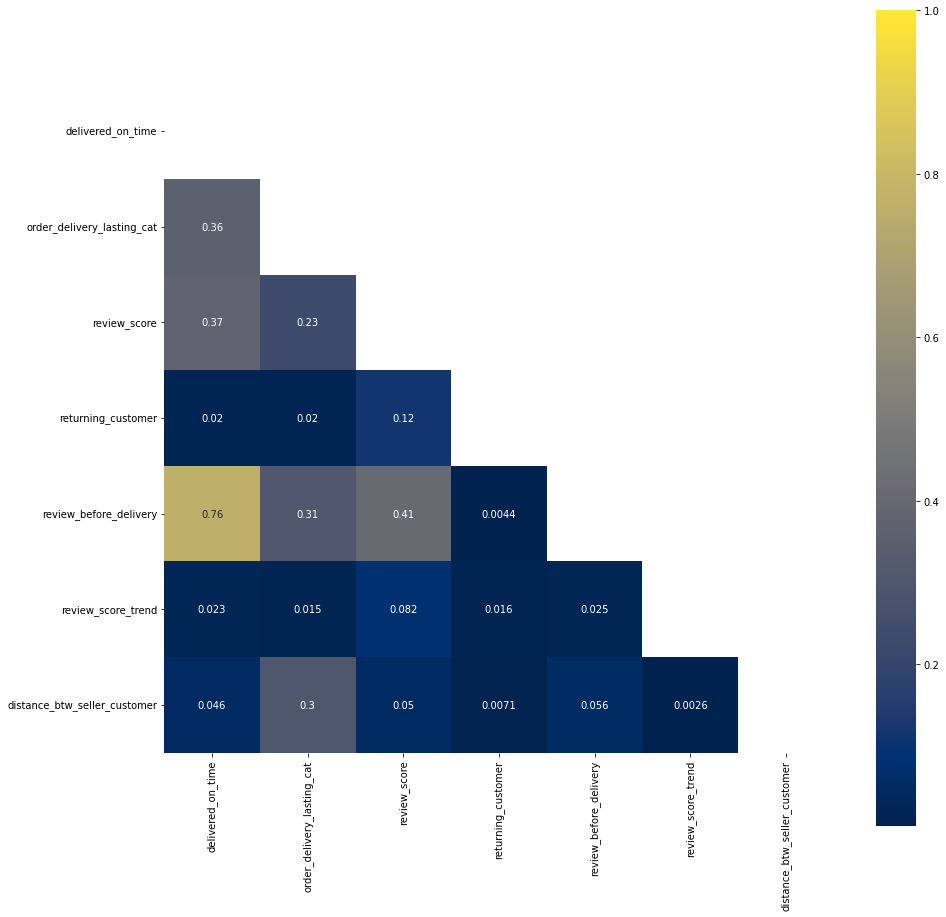

In [74]:
# features correlations
def show_feat_correlations(df):
	correlations = np.abs(df.select_dtypes(['float', 'int', 'bool']).corr(method="pearson"))

	mask = np.zeros_like(correlations)
	mask[np.triu_indices_from(mask)] = True
	sns.axes_style("white")
	plt.subplots(figsize=(15,15))
	sns.heatmap(correlations, mask=mask, vmax=1, square=True, xticklabels=correlations.columns, yticklabels=correlations.columns, annot=True, cmap='cividis')

show_feat_correlations(olist)

In [75]:
olist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90176 entries, afbcfd0b9c5233e7ccc73428526fbb52 to 830d5b7aaa3b6f1e9ad63703bec97d23
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   last_order_purchase_timestamp  90176 non-null  datetime64[ns]
 1   delivered_on_time              90176 non-null  bool          
 2   order_delivery_lasting_cat     90176 non-null  int64         
 3   review_score                   90176 non-null  float64       
 4   product_weight                 90176 non-null  int8          
 5   returning_customer             90176 non-null  bool          
 6   cumulated_price                90176 non-null  int8          
 7   review_before_delivery         90176 non-null  bool          
 8   review_score_trend             90176 non-null  float64       
 9   distance_btw_seller_customer   90176 non-null  int64         
dtypes: bool(3), datetime64[ns](1)

In [76]:
olist

,last_order_purchase_timestamp,delivered_on_time,order_delivery_lasting_cat,review_score,product_weight,returning_customer,cumulated_price,review_before_delivery,review_score_trend,distance_btw_seller_customer
customer_unique_id,,,,,,,,,,
afbcfd0b9c5233e7ccc73428526fbb52,2018-08-29,True,1,5.0,0,True,3,False,0.0,2
7a22d14aa3c3599238509ddca4b93b01,2018-08-29,True,1,1.0,2,False,1,False,0.0,1
0421e7a23f21e5d54efed456aedbc513,2018-08-29,True,1,5.0,2,False,2,False,0.0,2
0c6d7218d5f3fa14514fd29865269993,2018-08-29,True,1,5.0,0,False,2,False,0.0,2
5c58de6fb80e93396e2f35642666b693,2018-08-29,True,1,5.0,3,True,3,False,0.0,1
...,...,...,...,...,...,...,...,...,...,...
7390ed59fa1febbfda31a80b4318c8cb,2016-10-03,True,4,5.0,3,False,2,False,0.0,4
10e89fd8e5c745f81bec101207ba4d7d,2016-10-03,True,4,1.0,2,False,1,False,0.0,4
61db744d2f835035a5625b59350c6b63,2016-10-03,True,4,3.0,2,False,0,False,0.0,1


In [77]:
olist_bak = olist.copy()

## Univariate & Multivariate Analysis

<AxesSubplot:>

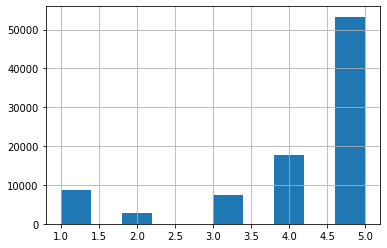

In [78]:
olist['review_score'].hist()

## Modelisation

In [79]:
olist.info()


<class 'pandas.core.frame.DataFrame'>
Index: 90176 entries, afbcfd0b9c5233e7ccc73428526fbb52 to 830d5b7aaa3b6f1e9ad63703bec97d23
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   last_order_purchase_timestamp  90176 non-null  datetime64[ns]
 1   delivered_on_time              90176 non-null  bool          
 2   order_delivery_lasting_cat     90176 non-null  int64         
 3   review_score                   90176 non-null  float64       
 4   product_weight                 90176 non-null  int8          
 5   returning_customer             90176 non-null  bool          
 6   cumulated_price                90176 non-null  int8          
 7   review_before_delivery         90176 non-null  bool          
 8   review_score_trend             90176 non-null  float64       
 9   distance_btw_seller_customer   90176 non-null  int64         
dtypes: bool(3), datetime64[ns](1)

### Raw KMeans 

In [80]:
olist = olist_bak.copy()

In [81]:
olist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90176 entries, afbcfd0b9c5233e7ccc73428526fbb52 to 830d5b7aaa3b6f1e9ad63703bec97d23
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   last_order_purchase_timestamp  90176 non-null  datetime64[ns]
 1   delivered_on_time              90176 non-null  bool          
 2   order_delivery_lasting_cat     90176 non-null  int64         
 3   review_score                   90176 non-null  float64       
 4   product_weight                 90176 non-null  int8          
 5   returning_customer             90176 non-null  bool          
 6   cumulated_price                90176 non-null  int8          
 7   review_before_delivery         90176 non-null  bool          
 8   review_score_trend             90176 non-null  float64       
 9   distance_btw_seller_customer   90176 non-null  int64         
dtypes: bool(3), datetime64[ns](1)

<AxesSubplot:ylabel='None'>

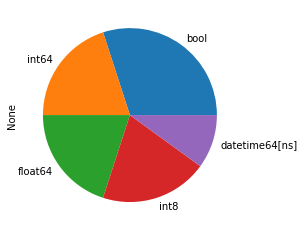

In [82]:
olist.dtypes.value_counts().plot.pie()

In [83]:
olist.describe()

,order_delivery_lasting_cat,review_score,product_weight,cumulated_price,review_score_trend,distance_btw_seller_customer
count,90176.000000,90176.000000,90176.000000,90176.000000,90176.000000,90176.000000
mean,2.427542,4.154476,1.449687,1.368113,0.000632,2.467109
std,1.124817,1.284417,1.144836,1.098849,0.106092,1.147838
min,1.000000,1.000000,0.000000,0.000000,-1.000000,1.000000
25%,1.000000,4.000000,0.000000,0.000000,0.000000,1.000000
50%,2.000000,5.000000,1.000000,1.000000,0.000000,2.000000
75%,3.000000,5.000000,2.000000,2.000000,0.000000,4.000000
max,4.000000,5.000000,3.000000,3.000000,1.000000,4.000000


In [84]:
olist.select_dtypes('number')

,order_delivery_lasting_cat,review_score,product_weight,cumulated_price,review_score_trend,distance_btw_seller_customer
customer_unique_id,,,,,,
afbcfd0b9c5233e7ccc73428526fbb52,1,5.0,0,3,0.0,2
7a22d14aa3c3599238509ddca4b93b01,1,1.0,2,1,0.0,1
0421e7a23f21e5d54efed456aedbc513,1,5.0,2,2,0.0,2
0c6d7218d5f3fa14514fd29865269993,1,5.0,0,2,0.0,2
5c58de6fb80e93396e2f35642666b693,1,5.0,3,3,0.0,1
...,...,...,...,...,...,...
7390ed59fa1febbfda31a80b4318c8cb,4,5.0,3,2,0.0,4
10e89fd8e5c745f81bec101207ba4d7d,4,1.0,2,1,0.0,4
61db744d2f835035a5625b59350c6b63,4,3.0,2,0,0.0,1


In [85]:
olist.select_dtypes(exclude='number')

,last_order_purchase_timestamp,delivered_on_time,returning_customer,review_before_delivery
customer_unique_id,,,,
afbcfd0b9c5233e7ccc73428526fbb52,2018-08-29,True,True,False
7a22d14aa3c3599238509ddca4b93b01,2018-08-29,True,False,False
0421e7a23f21e5d54efed456aedbc513,2018-08-29,True,False,False
0c6d7218d5f3fa14514fd29865269993,2018-08-29,True,False,False
5c58de6fb80e93396e2f35642666b693,2018-08-29,True,True,False
...,...,...,...,...
7390ed59fa1febbfda31a80b4318c8cb,2016-10-03,True,False,False
10e89fd8e5c745f81bec101207ba4d7d,2016-10-03,True,False,False
61db744d2f835035a5625b59350c6b63,2016-10-03,True,False,False


In [86]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from sklearn.pipeline import Pipeline, make_pipeline


size = 5000

olist_labels = olist.sort_values('last_order_purchase_timestamp', ascending=True)\
    .drop(['product_weight', 'review_before_delivery', 'distance_btw_seller_customer'], axis=1)\
    .sample(size, random_state=0)
olist_labels

,last_order_purchase_timestamp,delivered_on_time,order_delivery_lasting_cat,review_score,returning_customer,cumulated_price,review_score_trend
customer_unique_id,,,,,,,
9148a35e58b350858a25d1fad315ccb1,2018-07-11,True,1,4.0,False,1,0.0
1cedeea6974a8da4a99ef0b6e399eed2,2018-04-14,True,2,5.0,False,2,0.0
512fb1458489ea660743fb8d6e1449e1,2017-08-13,True,2,2.0,False,2,0.0
0cbd5dfde4c06bbe2960d2c0c95e5e7d,2017-08-02,True,2,5.0,False,3,0.0
ce6adb9b3e23ca6736f4b3d6038385f6,2018-04-19,True,4,5.0,False,3,0.0
...,...,...,...,...,...,...,...
50c331e195b1b8f694e1a20c147b0539,2018-08-06,True,1,5.0,False,2,0.0
f5ff85b902f67682997fe98003cd134e,2018-08-04,True,1,5.0,False,1,0.0
346d71fbd5abd26639668d14eb272515,2017-08-10,True,2,5.0,False,0,0.0


In [87]:

olist_light = olist_labels\
    .select_dtypes(exclude=['datetime', 'timedelta'])\

olist_light


,delivered_on_time,order_delivery_lasting_cat,review_score,returning_customer,cumulated_price,review_score_trend
customer_unique_id,,,,,,
9148a35e58b350858a25d1fad315ccb1,True,1,4.0,False,1,0.0
1cedeea6974a8da4a99ef0b6e399eed2,True,2,5.0,False,2,0.0
512fb1458489ea660743fb8d6e1449e1,True,2,2.0,False,2,0.0
0cbd5dfde4c06bbe2960d2c0c95e5e7d,True,2,5.0,False,3,0.0
ce6adb9b3e23ca6736f4b3d6038385f6,True,4,5.0,False,3,0.0
...,...,...,...,...,...,...
50c331e195b1b8f694e1a20c147b0539,True,1,5.0,False,2,0.0
f5ff85b902f67682997fe98003cd134e,True,1,5.0,False,1,0.0
346d71fbd5abd26639668d14eb272515,True,2,5.0,False,0,0.0


In [88]:

numerical_features = olist_light\
    .select_dtypes('number').columns

categorical_features = olist_light.select_dtypes(include=['object']).columns


preprocessor = ColumnTransformer([
    # ('scaler', MinMaxScaler(), numerical_features),
    # ('label', OrdinalEncoder(), categorical_features)
])


In [89]:
categorical_features

Index([], dtype='object')

In [90]:
numerical_features

Index(['order_delivery_lasting_cat', 'review_score', 'cumulated_price',
       'review_score_trend'],
      dtype='object')

In [91]:
olist_light.head()

,delivered_on_time,order_delivery_lasting_cat,review_score,returning_customer,cumulated_price,review_score_trend
customer_unique_id,,,,,,
9148a35e58b350858a25d1fad315ccb1,True,1,4.0,False,1,0.0
1cedeea6974a8da4a99ef0b6e399eed2,True,2,5.0,False,2,0.0
512fb1458489ea660743fb8d6e1449e1,True,2,2.0,False,2,0.0
0cbd5dfde4c06bbe2960d2c0c95e5e7d,True,2,5.0,False,3,0.0
ce6adb9b3e23ca6736f4b3d6038385f6,True,4,5.0,False,3,0.0


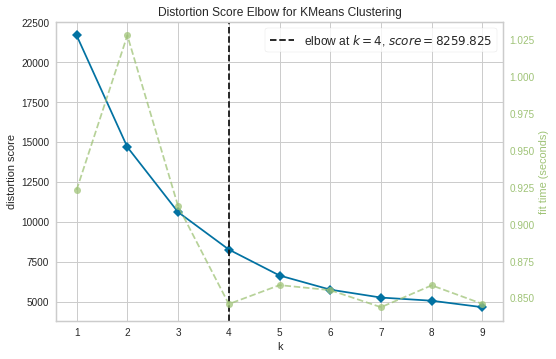

In [92]:
from yellowbrick.cluster import KElbowVisualizer

from sklearn.datasets import make_blobs

# visualizer = KElbowVisualizer(KMeans(), k=(1,10))

visualizer = Pipeline([
    # ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(random_state=0), k=(1,10)) )
])

visualizer.fit(olist_light)
visualizer.named_steps['kelbowvisualizer'].show()
elbow_score = visualizer.named_steps['kelbowvisualizer'].elbow_value_


In [93]:


model = Pipeline([
    # ("preprocessor", preprocessor),
    ("kmeans", KMeans(elbow_score, random_state=0))
])
model.fit(olist_light)

Pipeline(steps=[('kmeans', KMeans(n_clusters=4, random_state=0))])

/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


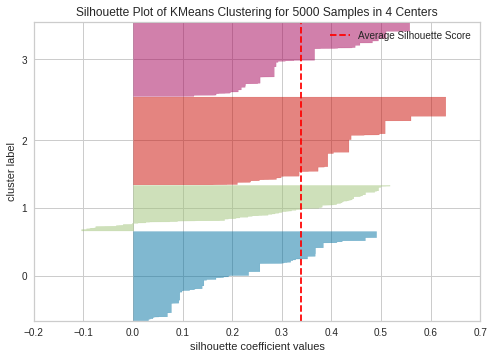

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 5000 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [94]:
from yellowbrick.cluster import SilhouetteVisualizer

silouhette_visualizer = Pipeline([
    # ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(model.named_steps['kmeans'], colors='yellowbrick'))
])

# silouhette_visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

silouhette_visualizer.fit(olist_light)
silouhette_visualizer.named_steps['silhouettevisualizer'].show()


/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


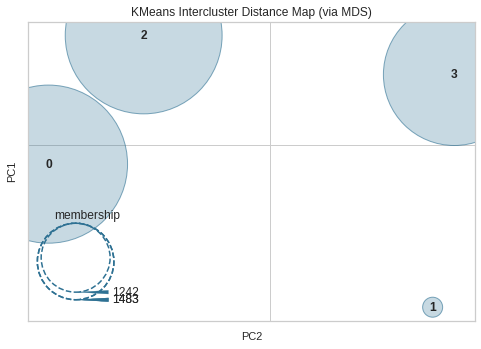

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [95]:
from yellowbrick.cluster import InterclusterDistance

intercluster = Pipeline([
    # ("preprocessor", preprocessor),
    ("intercluster", InterclusterDistance(model.named_steps['kmeans']))
])

intercluster.fit(olist_light)
intercluster.named_steps['intercluster'].show()


In [96]:
# apply labels to dataset
kmeans_labels = model.named_steps['kmeans'].labels_
olist_clustered = olist_light.copy()
olist_clustered['cluster_label'] = kmeans_labels

In [97]:
# group by labels and set average values for each cluster
olist_clustered = olist_clustered.groupby('cluster_label').mean().reset_index()
olist_clustered

,cluster_label,delivered_on_time,order_delivery_lasting_cat,review_score,returning_customer,cumulated_price,review_score_trend
0,0,0.899070,3.537185,4.584329,0.078353,1.195883,0.002656
1,1,0.677503,3.106632,1.531860,0.188557,1.605982,-0.009103
2,2,0.991908,1.465947,4.633176,0.064059,0.472690,0.000674
3,3,0.993559,1.742351,4.662641,0.184380,2.532206,0.004831


In [98]:
# prepare data for visualization
olist_clustered_scaled = preprocessing.StandardScaler().fit_transform(olist_clustered.drop('cluster_label', axis=1))
olist_clustered_scaled

array([[ 0.06646723,  1.22379964,  0.54560271, -0.87235484, -0.34374513,
         0.54283752],
       [-1.65392929,  0.73326549, -1.73167372,  1.0319378 ,  0.20733157,
        -1.66477328],
       [ 0.7873233 , -1.13598768,  0.58204445, -1.11935101, -1.31554692,
         0.17078369],
       [ 0.80013876, -0.82107744,  0.60402656,  0.95976806,  1.45196047,
         0.95115208]])

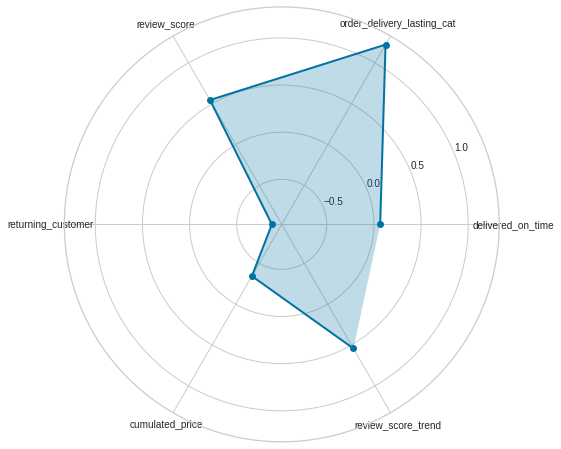

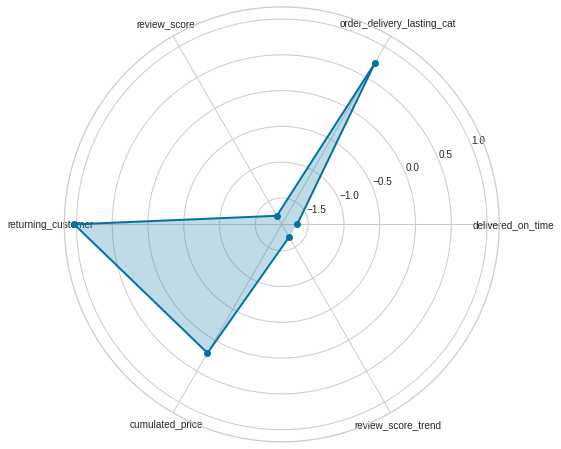

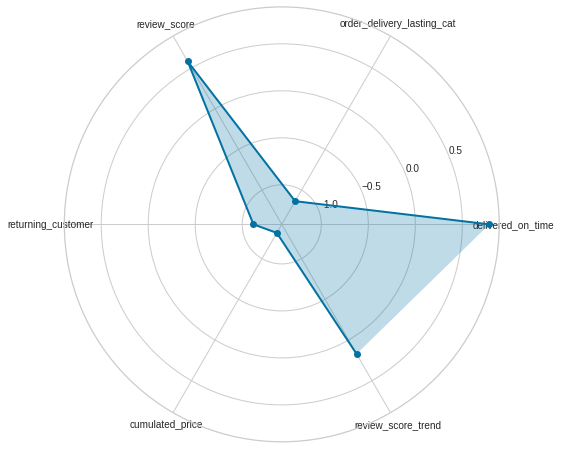

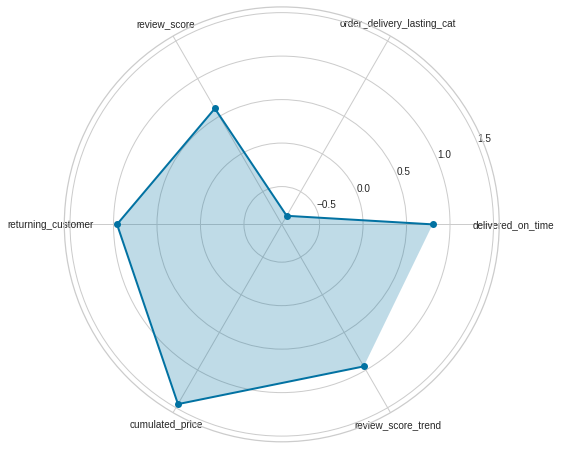

In [99]:
labels=olist_clustered.drop('cluster_label', axis=1).columns.values
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)

for row in olist_clustered_scaled:
    # row = row[1:]
    # print(row)
    fig = plt.figure(figsize=(8,8))
    ax=fig.add_subplot(111, polar=True)
    ax.plot(angles, row, 'o-', linewidth=2)
    ax.fill(angles, row, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.grid(True)



We can see 4 clusters:
* good and returning customers, with average review score : delivery time is very low, and delivered on time
* one-order customers, with good review score, despite long delivery delay, but delivered on time
* one-order customer, veru good review, delivery is done before estimated and very short
* good and returning customer, but with poor review score, delivery is not made on time and quite long. review score trend is lowering

### Apply PCA

computing PCA dimension reduction on range(0, 6) features
cumulated variance explined by PCA: [0.43906063 0.72311377 0.96203937 0.98461971 0.99816603 1.        ]


([<matplotlib.axis.XTick at 0x7fdf40f4e5b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

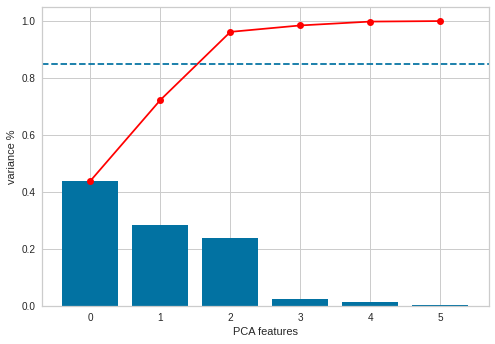

In [100]:
from sklearn import decomposition

pipeline = Pipeline([
    # ("preprocessor", preprocessor),
    ("pca", decomposition.PCA(svd_solver='full'))
])

pipeline.fit(olist_light)
olist_projected = pd.DataFrame(pipeline.transform(olist_light))
pca = pipeline.named_steps['pca']


features = range(pca.n_components_)
print(f'computing PCA dimension reduction on {features} features')
cumulated = np.cumsum(pca.explained_variance_ratio_)
print(f'cumulated variance explined by PCA: {cumulated}')
plt.bar(features, pca.explained_variance_ratio_)
plt.plot(features, cumulated, marker='o', c='red')
plt.axhline(y=0.85, linestyle='--')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)


In [101]:
# We choose 3 components in order to explain 85% of variance
n_pca = 3

In [102]:
import plotly.express as px

fig = px.scatter_matrix(
    olist_projected,
    labels=olist_projected.columns,
    dimensions=range(n_pca),
    # color=olist_light['review_score']
)
fig.update_traces(diagonal_visible=False)
fig.show()

/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/pandas/core/indexes/base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [103]:
olist_projected.columns = olist_projected.columns.astype(str)

fig = px.scatter_3d(
    olist_projected, x='0', y='1', z='2', color='3',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    # width=15, height=15
)
fig.show()

### Kmeans Refined

In [104]:
olist_projected = olist_projected.iloc[:,:n_pca]
olist_projected

,0,1,2
0,-0.694019,0.763198,1.046276
1,-0.826539,-0.745047,0.205425
2,1.655673,0.299860,1.510243
3,-0.659019,-1.644031,0.604157
4,0.395707,-2.165948,-1.005131
...,...,...,...
4995,-1.353902,-0.484088,1.010069
4996,-1.521423,0.414896,0.611337
4997,-1.161580,1.052923,-0.592039
4998,2.669046,-0.298840,2.399705


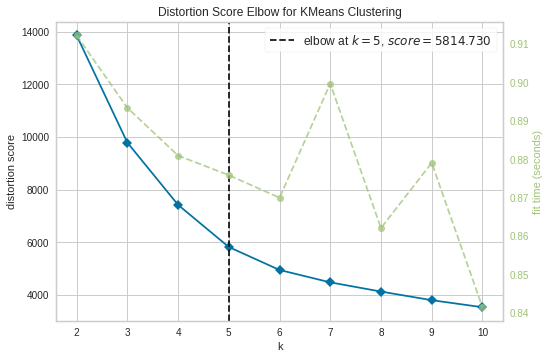

In [105]:

visualizer_pca = Pipeline([
    ("kelbowvisualizer", KElbowVisualizer(KMeans(random_state=0),K=(1,12)))])

visualizer_pca.fit(olist_projected)
visualizer_pca.named_steps['kelbowvisualizer'].show()
elbow_score = visualizer_pca.named_steps['kelbowvisualizer'].elbow_value_

model = KMeans(elbow_score)

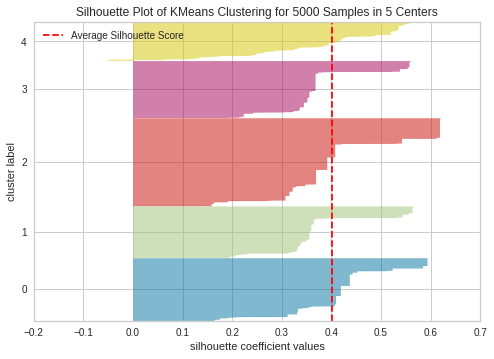

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 5000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [106]:

silouhette_visualizer_pca = Pipeline([
    ("silhouettevisualizer", SilhouetteVisualizer(model, colors='yellowbrick'))
])

# SilhouetteVisualizer(model, colors='yellowbrick')

silouhette_visualizer_pca.fit(olist_projected)
silouhette_visualizer_pca.named_steps['silhouettevisualizer'].show()


/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/sklearn/base.py:441: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



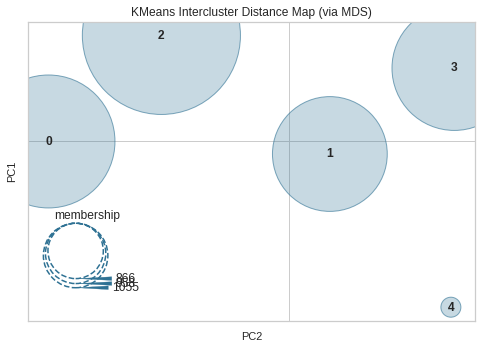

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [107]:
intercluster_pca = Pipeline([
    ("intercluster", InterclusterDistance(model))
])

intercluster_pca.fit(olist_projected)
intercluster_pca.named_steps['intercluster'].show()

In [108]:
# apply labels to dataset
kmeans_labels = model.labels_

olist_labels['cluster_label'] = kmeans_labels

In [109]:
# average values for each cluster

olist_clustered = olist_labels.groupby('cluster_label').mean().reset_index()
olist_clustered

,cluster_label,delivered_on_time,order_delivery_lasting_cat,review_score,returning_customer,cumulated_price,review_score_trend
0,0,0.995261,1.519431,4.647393,0.172512,2.449289,0.002844
1,1,0.912240,3.489607,4.503464,0.162818,2.491917,0.006928
2,2,0.991908,1.465947,4.633176,0.064059,0.472690,0.000674
3,3,0.894572,3.470772,4.472860,0.050104,0.507307,-0.001044
4,4,0.645768,3.025078,1.230408,0.189655,1.493730,-0.007837


In [110]:
# prepare data for visualization
olist_clustered_scaled = preprocessing.StandardScaler().fit_transform(olist_clustered.drop('cluster_label', axis=1))
olist_clustered_scaled

array([[ 0.83996237, -1.17489125,  0.5616201 ,  0.76291433,  1.090709  ,
         0.51966134],
       [ 0.19012972,  0.97888648,  0.45383247,  0.59739161,  1.13882487,
         1.35851175],
       [ 0.81372211, -1.23335931,  0.5509728 , -1.08882962, -1.1403669 ,
         0.074178  ],
       [ 0.05183436,  0.95829629,  0.43091328, -1.32709985, -1.10129382,
        -0.27865919],
       [-1.89564855,  0.47106779, -1.99733865,  1.05562353,  0.01212685,
        -1.67369191]])

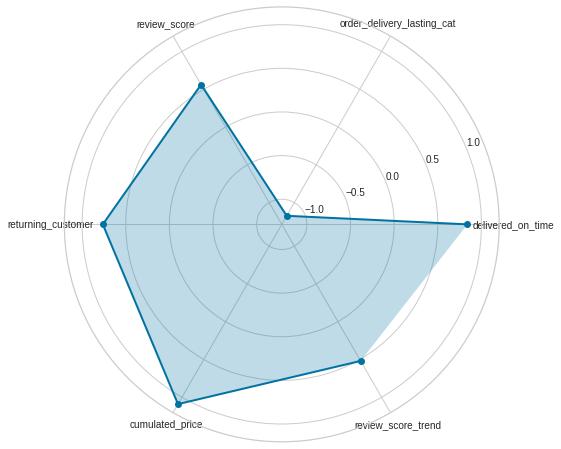

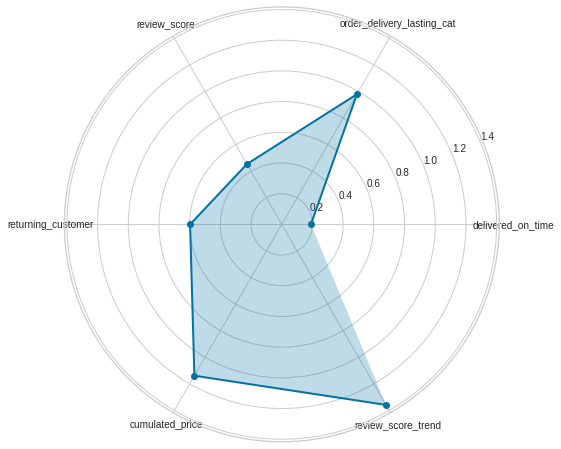

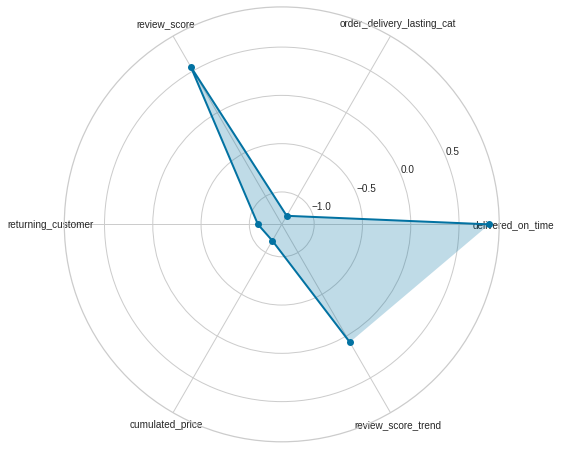

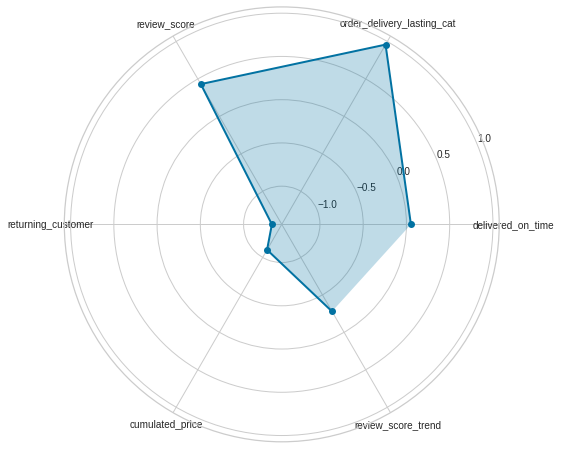

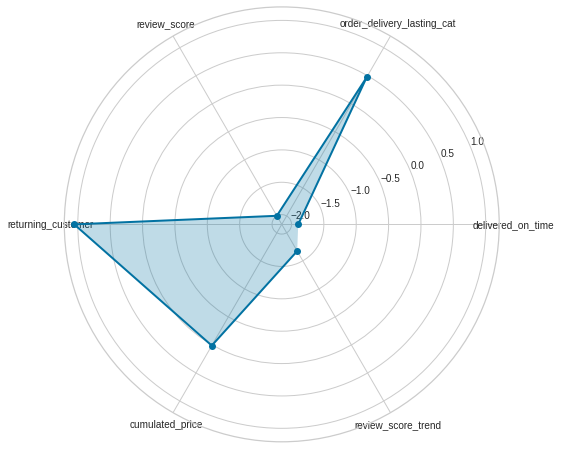

In [111]:
labels=olist_clustered.drop('cluster_label', axis=1).columns.values
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)

for row in olist_clustered_scaled:
    # row = row[1:]
    # print(row)
    fig = plt.figure(figsize=(8,8))
    ax=fig.add_subplot(111, polar=True)
    ax.plot(angles, row, 'o-', linewidth=2)
    ax.fill(angles, row, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.grid(True)



We now have 5 clusters, four are the same than previously, but we have another one :
* good customer, not necessarily returning, with above average review score, but trend is raising, thanks to delivered time way above estimated (average delivery delay)



In [112]:
olist_bck_stability = olist.copy()

## Stability

In [356]:
olist = olist_bck_stability.copy()

In [357]:
olist.groupby([olist['last_order_purchase_timestamp'].dt.to_period('M')])['review_score'].count().to_frame()

,review_score
last_order_purchase_timestamp,
2016-09,1
2016-10,253
2017-01,663
2017-02,1506
2017-03,2300
2017-04,2083
2017-05,3186
2017-06,2818
2017-07,3546


[1, 0.8408876898933545, 0.8456996357744518, 0.7525897242700905, 0.8255108544136719, 0.668341055064765, 0.7046430432373585, 0.6465950255114927, 0.6612118998136035]


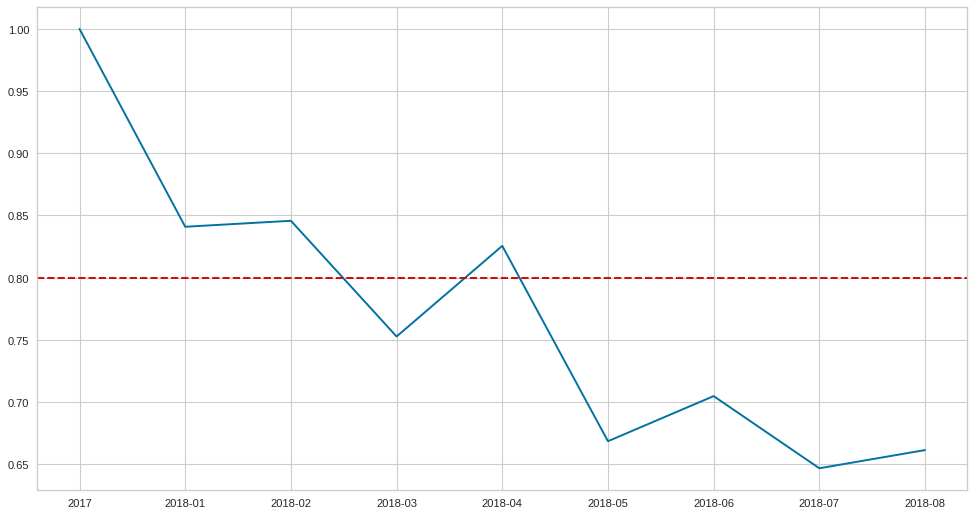

In [113]:
from sklearn.metrics.cluster import adjusted_rand_score as ari 


# olist_2017 = olist.groupby([olist['last_order_purchase_timestamp'].dt.to_period('Y')]).get_group(pd.Period('2017', 'Y'))
mask = (olist['last_order_purchase_timestamp'] > '2017-01-01') & (olist['last_order_purchase_timestamp'] < '2018-01-01')
olist_2017 = olist.loc[mask]

# train initial model on whole year 2017, thus we have the most customers and the most precise clustering
model_2017 = Pipeline([
        ("kmeans", KMeans(elbow_score, random_state=0))]
    )
model_2017.fit(olist_2017.select_dtypes('number'))

# model 2018 will be trained for each month
model_2018 = Pipeline([
        ("kmeans", KMeans(elbow_score, random_state=0))]
    )


ari_array = [1] #first element represents 100%, our base start
ari_array_legend = ['2017']
for m in range(1, 9):
    month = '2018-0' + str(m)
    # select dataset for the next month
    olist_2018 = olist.groupby([olist['last_order_purchase_timestamp'].dt.to_period('M')])\
        .get_group(pd.Period(month, 'M'))

    ari_array.append(
        ari(
            model_2018.fit(olist_2018.select_dtypes('number')).named_steps['kmeans'].labels_, # what does the new model gives as result : expected
            model_2017.predict(olist_2018.select_dtypes('number')), #what does the old model would predict : given
    ))
    ari_array_legend.append(month)

    

print(ari_array)

plt.figure(figsize=(15, 8), dpi=80)
plt.plot(ari_array_legend, ari_array)
plt.axhline(y=0.80, color='r', linestyle='--')

After 3 months, the ari is below 80%, so we can consider the clustering predictions quite poor, so we should consider a maintenance of every quarters.

In [124]:
def select_btw_dates(date_start, date_stop, olist) :
    mask = (olist['last_order_purchase_timestamp'] >= date_start) & (olist['last_order_purchase_timestamp'] < date_stop)
    return olist.loc[mask]

getting data between 2017-12-01 and 2018-01-01
getting data between 2018-01-01 and 2018-02-01
getting data between 2018-02-01 and 2018-03-01
getting data between 2018-03-01 and 2018-04-01
getting data between 2018-04-01 and 2018-05-01
getting data between 2018-05-01 and 2018-06-01
getting data between 2018-06-01 and 2018-07-01
getting data between 2018-07-01 and 2018-08-01
[1, 0.9754930769626894, 0.8408876898933545, 0.8456996357744518, 0.7525897242700905, 0.8255108544136719, 0.668341055064765, 0.7046430432373585, 0.6465950255114927]


Text(0.5, 1.0, 'model prediction stability, with cumulative datas = False')

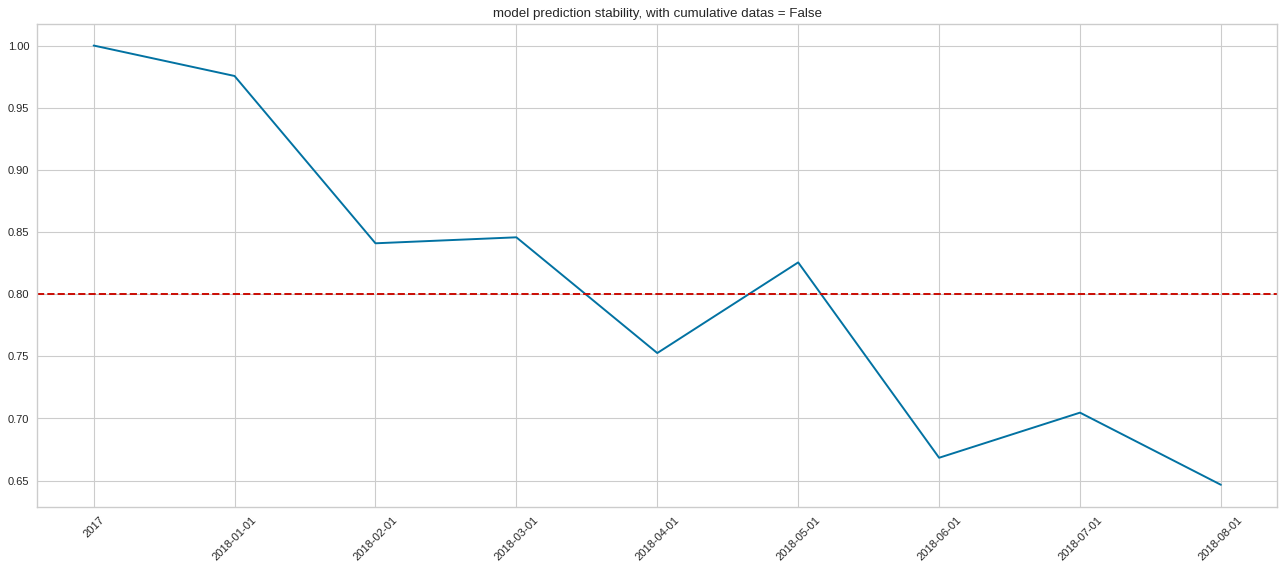

In [150]:
from sklearn.metrics.cluster import adjusted_rand_score as ari 

# olist_2017 = olist.groupby([olist['last_order_purchase_timestamp'].dt.to_period('Y')]).get_group(pd.Period('2017', 'Y'))
olist_2017 = select_btw_dates('2017-01-01', '2018-01-01', olist)
# train initial model on whole year 2017, thus we have the most customers and the most precise clustering
model_2017 = Pipeline([
        ("kmeans", KMeans(elbow_score, random_state=0))]
    )
model_2017.fit(olist_2017.select_dtypes('number'))


# model 2018 will be trained for each month
olist_2018 = olist_2017.copy()
model_2018 = Pipeline([
        ("kmeans", KMeans(elbow_score, random_state=0))]
    )


ari_array = [1] #first element represents 100%, our base start
ari_array_legend = ['2017']

month_label = '2018-01'
cumulative_flag = False

for m in range(1, 9):
    if (cumulative_flag) : 
        month_label_0 = '2017-01-01'
    else :
        if (m == 1):
            month_label_0 = '2017-12-01'
        else: 
            month_label_0 = '2018-0' + str(m-1) + '-01'

    # select dataset for the next month
    month_label = '2018-0' + str(m) + '-01'
    print(f'getting data between {month_label_0} and {month_label}')

    olist_2018 = select_btw_dates(month_label_0, month_label, olist)

    ari_array.append(
        ari(
            model_2018.fit(olist_2018.select_dtypes('number')).named_steps['kmeans'].labels_, # what does the new model gives as result : expected
            model_2017.predict(olist_2018.select_dtypes('number')), #what does the old model would predict : given
    ))
    ari_array_legend.append(month_label)
    

    

print(ari_array)

plt.figure(figsize=(20, 8), dpi=80)
plt.plot(ari_array_legend, ari_array)
plt.axhline(y=0.80, color='r', linestyle='--')
plt.xticks(rotation=45)
plt.title(f'model prediction stability, with cumulative datas = {cumulative_flag}')